In [190]:
import heapq
from heapq import heappush, heappop

import math
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
place_name = "Redlands, California, United States"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph, node_size=2, bgcolor = 'white', node_color='blue')
plt.tight_layout()

In [2]:
area = ox.geocode_to_gdf(place_name)
area

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((-117.24978 34.07062, -117.2497...","Redlands, San Bernardino County, California, U...",34.101629,34.003999,-117.051457,-117.249785


In [3]:
buildings = ox.footprints.footprints_from_place(place_name)

In [17]:
hospitals = buildings[buildings.building == "hospital"]

In [4]:
nodes, edges = ox.graph_to_gdfs(graph)

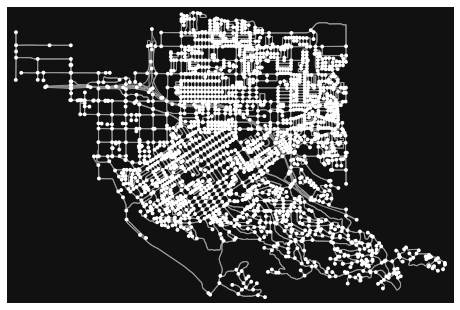

<Figure size 432x288 with 0 Axes>

In [6]:
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)
plt.tight_layout()

In [7]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [ ]:
hospitals = ox.

In [31]:
def Haversine(lat1, lat2, lon1, lon2):
    radius = 6371 
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2))
    return radius * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [32]:
def dist(lat1, lat2, lon1, lon2):
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**.5

In [33]:
def get_node(latitude, longitude, nodes):
    minner, mindex = float("inf"), -1
    for index, row in nodes.iterrows():
        distance = dist(latitude, row["lat"], longitude, row["lon"])
        if distance < minner:
            minner = distance
            mindex = index
    return mindex

In [34]:
def get_hospitals(nodes, hospitals):
    hosps = []
    noder = []
    for index, row in hospitals.iterrows():
        hosps.append(list(hospitals.geometry.loc[index].centroid.coords)[0])
    for hosp in hosps:
        noder.append(get_node(hosp[1], hosp[0], nodes))
    return list(set(noder))

In [35]:
hospers = get_hospitals(nodes_proj, hospitals)

In [118]:
esri = get_node(34.05608640000003, -117.19569523299998, nodes_proj)
apt = get_node(34.04472649163186, -117.20520037855628, nodes_proj)
walmart = get_node(34.065378, -117.222253, nodes_proj)

In [119]:
sourced = [esri, apt, walmart]

In [197]:
def shortest_path_nx(graph_proj, sourced, hospitals):
    paths = {}
    path_lengths = {}
    all_paths = []
    for source in sourced:
        paths[source] = -1
        path_lengths[source] = float("inf")
    for sourcer in sourced:
        for hosper in hospitals:
            curr = nx.dijkstra_path(G=graph_proj, source=sourcer, target=hosper, weight='length')
            length = nx.dijkstra_path_length(G=graph_proj, source=sourcer, target=hosper, weight='length')
            all_paths.append(curr)
            if length < path_lengths[sourcer]:
                paths[sourcer] = curr
                path_lengths[sourcer] = length
    return paths, path_lengths, all_paths

In [209]:
### Original implementation of Dijkstra using a minheap.
### takes in G: a NX graph object
### and source: a numerical index of G, and target: a numerical index of G

def dijkstra(G, source, target): 
    if not source:
        raise ValueError('need source')
    if not source in G:
        raise AssertionError("Source not in Graph")
    if not target in G:
        raise AssertionError("Target not in Graph")
    if target == source:
        return (0, [target])
    paths = {source: [source]}
    dist = {} 
    heap = []
    seen = {source : 0}
    heappush(heap, (0, source))
    while heap:
        (d, v) = heappop(heap)
        if v in dist:
            continue
        dist[v] = d
        if v == target:
            break
        struc = G._succ[v]
        nexter, edge = struc.keys(), list(struc.values())
        for j in range(len(struc)):
            length = list(list(edge)[j].values())[0]['length']
            min_node = list(nexter)[j]
            new_dist = dist[v] + length
            if not min_node in seen or new_dist < seen[min_node]:
                seen[min_node] = new_dist
                heappush(heap, (new_dist, min_node))
                paths[min_node] = paths[v] + [min_node]
    return paths[target], dist[target]

In [199]:
def shortest_path_dijk(graph_proj, sourced, hospitals):
    paths = {}
    path_lengths = {}
    all_paths = []
    for source in sourced:
        paths[source] = -1
        path_lengths[source] = float("inf")
    for sourcer in sourced:
        for hosper in hospitals:
            curr, length = dijkstra(G=graph_proj, source=sourcer, target=hosper)
            all_paths.append(curr)
            if length < path_lengths[sourcer]:
                paths[sourcer] = curr
                path_lengths[sourcer] = length
    return paths, path_lengths, all_paths

In [200]:
hospital_paths_nx = shortest_path_nx(graph_proj, sourced, hospers)
nx_paths, nx_lengths, nx_all = hospital_paths_nx

In [201]:
hospital_paths_dijk = shortest_path_dijk(graph_proj, sourced, hospers)
dijk_paths, dijk_lengths, dijk_all = hospital_paths_nx

In [207]:
def dijkstra_implementation_equivalent(nx_paths, nx_lengths, dijk_paths, dijk_lengths):
    if nx_paths != dijk_paths:
        raise AssertionError("Dijkstra Paths not same as NetworkX")
    if nx_lengths != dijk_lengths:
        raise AssertionError("Dijkstra Path Lengths not same as NetworkX")
    print("Implemented Correctly!")    

In [208]:
dijkstra_implementation_equivalent(nx_paths, nx_lengths, dijk_paths, dijk_lengths)

Implemented Correctly!


In [213]:
routes = list(dijk_paths.values())

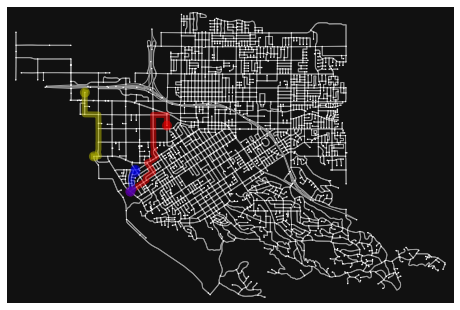

In [215]:
fig, ax = ox.plot_graph_routes(graph_proj, routes=[routes[0], routes[1], routes[2]], route_colors=['r', 'b', 'y'],
                               route_linewidth=6, node_size=2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

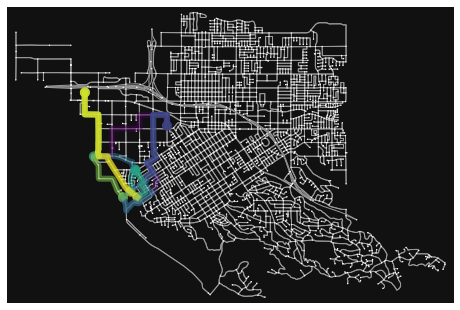

In [216]:
fig, ax = ox.plot_graph_routes(graph_proj, routes=dijk_all, route_colors=ox.plot.get_colors(12),
                               route_linewidth=6, node_size=2)

In [217]:
stats = ox.basic_stats(graph_proj)
stats

{'n': 2323,
 'm': 6037,
 'k_avg': 5.197589324149806,
 'intersection_count': 1785,
 'streets_per_node_avg': 2.745157124408093,
 'streets_per_node_counts': {0: 0, 1: 538, 2: 4, 3: 1307, 4: 460, 5: 14},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.23159707275075334,
  2: 0.0017219113215669393,
  3: 0.5626345243219975,
  4: 0.19801980198019803,
  5: 0.006026689625484288},
 'edge_length_total': 983437.0399999965,
 'edge_length_avg': 162.90161338413063,
 'street_length_total': 529097.7279999994,
 'street_length_avg': 167.33008475648305,
 'street_segments_count': 3162,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.83435745255022e-05,
 'self_loop_proportion': 0.0023190326321020373,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [ ]:
area = edges_proj.unary_union.convex_hull.area
stats = ox.basic_stats(graph_proj, area=area)
extended_stats = ox.extended_stats(graph_proj, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)